In [1]:
#reference : https://www.kaggle.com/librauee
import os
IS_COLAB = not os.path.exists('/kaggle/input')
print(IS_COLAB) 

False


In [2]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

2022-02-26 22:12:39.245082: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-26 22:12:39.245211: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Running on TPU  grpc://10.0.0.2:8470


2022-02-26 22:12:44.130505: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-26 22:12:44.133431: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-26 22:12:44.133473: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-26 22:12:44.133501: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (94febcbb390e): /proc/driver/nvidia/version does not exist
2022-02-26 22:12:44.137384: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [3]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from kaggle_datasets import KaggleDatasets

In [4]:
!pip install -q efficientnet
!pip install tensorflow_addons
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime

## Config

In [5]:
save_dir = '.'
EXPERIMENT = 0
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)
if IS_COLAB:
    save_dir = f'/content/drive/MyDrive/Kaggle/HappyWhale-2022/experiments-{EXPERIMENT}/{run_ts}'
    !mkdir -p {save_dir}

20220226-221309


In [6]:
class config:
    
    
    SEED = 42
    FOLD_TO_RUN = 0#In this notebook, we do not train models 
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 780 #768
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1'  
    EFF_NET = 6
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 0
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 100
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

False


In [7]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b6


In [8]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [9]:
GCS_PATH = 'gs://kds-d916c3252bf3bc5b3500b904f05f51ce57c8df85221d11b7711bcda9'  # Get GCS Path from kaggle notebook if GCS Path is expired
if not IS_COLAB:
    GCS_PATH = KaggleDatasets().get_gcs_path('happywhale-tfrecords-v1')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-6f96f0bc6a675e5d7d316d604702c92b164fc68a7fe681084b7a873d
10 10 51033 27956


2022-02-26 22:13:10.487325: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-26 22:13:10.571454: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


## Data

In [10]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image,0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    #image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

## Model

In [11]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [12]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        
        if config.model_type == 'effnetv1':
            x = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
            embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
            
        embed = tf.keras.layers.Dropout(0.2)(embed)
        embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

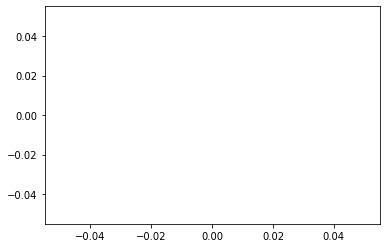

In [13]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [14]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

## Train

In [15]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

8 2 40826 10207


In [16]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [17]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

if config.RESUME:   
    model.load_weights(config.resume_model_wts)

165232640/165226952 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 780, 780, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b6 (Functional)    (None, None, None, 2 40960136    inp1[0][0]                       
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2304)         0           efficientnet-b6[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2304)         0           global_average_pooling2d[0][0]   
___________________________

In [18]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

embed_models=[]
for i in range(5):
    model,embed_model = get_model()
    embed_models.append((model.load_weights(f"../input/eff-b6-5fold/effnetv1_b6_loss_{i}.h5"),embed_model))
len(embed_models)

#### Image Size 780 with EfficientNet B6 and batch_size 256


5

## Evaluation

In [19]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = np.mean(np.stack([embed_models[x][1].predict(ds,verbose=0) for x in range(len(embed_models))]), axis=0)
    #print (embeddings.shape)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ('../input/happywhale-splits/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [20]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/8 [00:00<?, ?it/s]

2022-02-26 22:19:53.031827: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 436325, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1645913993.027890200","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 436325, Output num: 0","grpc_status":3}
2022-02-26 22:20:53.674401: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 438650, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task

In [21]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [22]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/2 [00:00<?, ?it/s]

2022-02-26 22:41:06.851158: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 452410, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1645915266.850987528","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 452410, Output num: 0","grpc_status":3}
2022-02-26 22:42:07.329980: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 453646, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task

In [23]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    2177
37c7aba965a5        79
114207cab555        40
e69d5f9f8d1e        33
ffbb4e585ff2        32
                  ... 
80f4e0d635a7         1
c3dad9e679f3         1
179af04b755d         1
b7065da154c5         1
5c0572fe9fc1         1
Name: target, Length: 3255, dtype: int64

In [24]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/10207 [00:00<?, ?it/s]

1      528
22     187
23     187
30     182
27     182
      ... 
3       12
94      11
98       7
100      3
99       2
Name: image, Length: 100, dtype: int64

## Inference

In [25]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51033, 512) (51033,)


In [26]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [27]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
for filename in tqdm(test_files):
    embeddings = get_embeddings(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

2022-02-26 22:46:18.363237: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 455623, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1645915578.363138576","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 455623, Output num: 0","grpc_status":3}
2022-02-26 22:47:48.926635: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 457162, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task

In [28]:
sample_submission = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

27956 27956


  0%|          | 0/27956 [00:00<?, ?it/s]

20     474
19     461
35     447
17     446
23     442
      ... 
97      56
96      50
98      45
99      22
100     16
Name: image, Length: 100, dtype: int64

In [29]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']
best_threshold_adjusted = 0.52
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27956 [00:00<?, ?it/s]

,image,predictions
0,3c52966f74d2ad.jpg,978520860ceb new_individual d4dfc9c0b367 a74a0...
1,d846a86edded63.jpg,03a3bbaeed84 new_individual 52a2c490b25a ce79e...
2,50df0a954eb94c.jpg,713eb1a00c3d new_individual b848a62e130b 8c78e...
3,0cfc88bad51a18.jpg,e4a55c745bd9 new_individual 1b434f154c89 5393a...
4,59bc2d264c9731.jpg,47a2f9918aa2 new_individual 73c68d52e748 82fa8...
